# How the PCA algorithm works

PCA makes several assumptions that are important to keep in mind. These include:
- high variance implies a high signal-to-noise ratio
- the data is standardized so that the variance is comparable across features
- linear transformations capture the relevant aspects of the data, and
- higher-order statistics beyond the first and second moment do not matter, which implies that the data has a normal distribution

The emphasis on the first and second moments align with standard risk/return metrics, but the normality assumption may conflict with the characteristics of market data.


The algorithm finds vectors to create a hyperplane of target dimensionality that minimizes the reconstruction error, measured as the sum of the squared distances of the data points to the plane. As illustrated above, this goal corresponds to finding a sequence of vectors that align with directions of maximum retained variance given the other components while ensuring all principal component are mutually orthogonal.

In practice, the algorithm solves the problem either by computing the eigenvectors of the covariance matrix or using the singular value decomposition. 

## Imports & Settings

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.linalg import inv, eig, svd
from numpy.random import uniform, randn, seed
from itertools import repeat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

In [2]:
sns.set_style('white')
seed(42)

In [3]:
def format3D(axis, labels=('x', 'y', 'z'), limits=None):
    """3D plot helper function to set labels, pane color, and axis limits"""
    axis.set_xlabel('\n${}$'.format(labels[0]), linespacing=3)
    axis.set_ylabel('\n${}$'.format(labels[1]), linespacing=3)
    axis.set_zlabel('\n${}$'.format(labels[2]), linespacing=3)
    transparent = (1.0, 1.0, 1.0, 0.0)
    axis.w_xaxis.set_pane_color(transparent)
    axis.w_yaxis.set_pane_color(transparent)
    axis.w_zaxis.set_pane_color(transparent)
    if limits:
        axis.set_xlim(limits[0])
        axis.set_ylim(limits[1])
        axis.set_zlim(limits[2])

## Create a noisy 3D Ellipse

We illustrate the computation using a randomly generated three-dimensional ellipse with 100 data points.

In [4]:
n_points, noise = 100, 0.1
angles = uniform(low=-np.pi, high=np.pi, size=n_points)
x = 2 * np.cos(angles) + noise * randn(n_points)
y = np.sin(angles) + noise * randn(n_points)

theta = np.pi/4 # 45 degree rotation
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta), np.cos(theta)]])

rotated = np.column_stack((x, y)).dot(rotation_matrix)
x, y = rotated[:, 0], rotated[:, 1]

z = .2 * x  + .2 * y + noise * randn(n_points)
data = np.vstack((x, y, z)).T

In [5]:
data.shape

(100, 3)

### Plot the result 

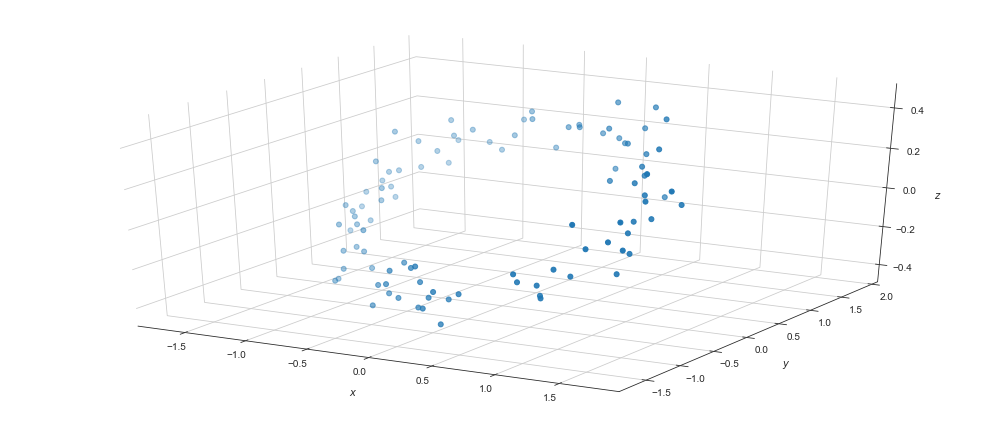

In [6]:
ax = plt.figure().gca(projection='3d')

ax.scatter(x, y, z, s=25)
format3D(ax)
plt.gcf().set_size_inches(14, 6)
plt.tight_layout();

## Principal Components using scikit-learn

The [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation follows the standard API based on fit() and transform() methods that compute the desired number of principal components and project the data into the component space, respectively. The convenience method fit_transform() accomplishes this in a single step.

PCA offers three different algorithms that can be specified using the svd_solver parameter: 
- full computes the exact SVD using the LAPACK solver provided by scipy, 
- arpack runs a truncated version suitable for computing less than the full number of components. 
- randomized uses a sampling-based algorithm that is more efficient when the data set has more than 500 observations and features, and the goal is to compute less than 80% of the components
- auto also randomized where most efficient, otherwise, it uses the full SVD. 

Other key configuration parameters of the PCA object are:
- n_components:  compute all principal components by passing None (the default), or limit the number to int. For svd_solver=full, there are two -additional options: a float in the interval [0, 1]  computes the number of components required to retain the corresponding share of the variance in the data, and the option mle estimates the number of dimensions using maximum likelihood.
- whiten: if True, it standardizes the component vectors to unit variance that in some cases can be useful for use in a predictive model (default is False) 

In [7]:
pca = PCA()
pca.fit(data)
C = pca.components_.T # columns = principal components
C

array([[ 0.71409739,  0.66929454,  0.20520656],
       [-0.70000234,  0.68597301,  0.1985894 ],
       [ 0.00785136,  0.28545725, -0.95835928]])

### First principal component

In [8]:
C[:, 0]

array([ 0.71409739, -0.70000234,  0.00785136])

### Explained Variance

In [9]:
explained_variance = pca.explained_variance_
explained_variance

array([1.92923132, 0.55811089, 0.00581353])

In [10]:
np.allclose(explained_variance/np.sum(explained_variance), 
            pca.explained_variance_ratio_)

True

### PCA to reduce dimensions

In [11]:
pca2 = PCA(n_components=2)
projected_data  = pca2.fit_transform(data)
projected_data.shape

(100, 2)

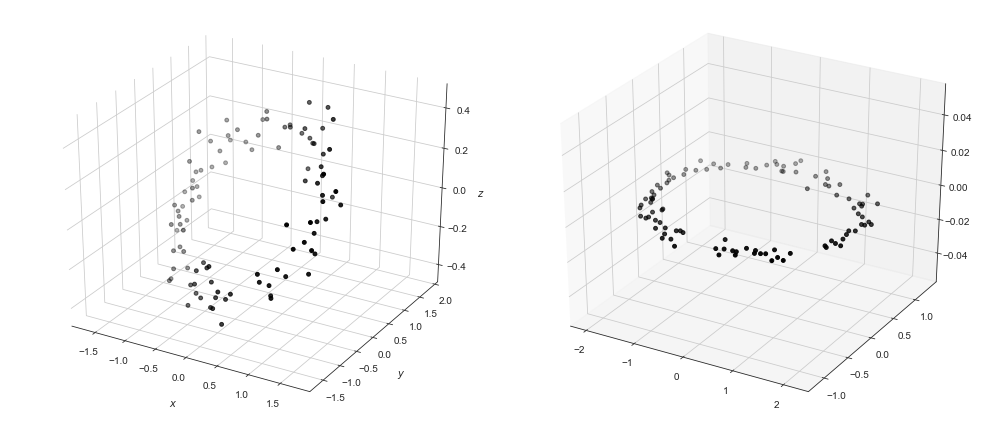

In [12]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(x, y, z, s=15, c='k')
format3D(ax1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(*projected_data.T, s=15, c='k')
format3D(ax1)
fig.tight_layout()

In [13]:
pca2.explained_variance_ratio_

array([0.77381099, 0.22385721])

## Principal Components from Covariance Matrix

We first compute the principal components using the square covariance matrix with the pairwise sample covariances for the features xi, xj, i, j = 1, ..., n as entries in row i and column j:
 
$$cov_{i,j}=\frac{\sum_{k=1}^{N}(x_{ik}−\bar{x_i})(x_{jk}−\bar{x_j})}{N−1}$$

Using `numpy`, we implement this as follows, where the pandas `DataFrame` data contains the 100 data points of the ellipse:

In [14]:
cov = np.cov(data.T) # each row represents a feature
cov.shape

(3, 3)

### Eigendecomposition: Eigenvectors & Eigenvalues 

- The Eigenvectors $w_i$ and Eigenvalues $\lambda_i$ for a square matrix $M$ are defined as follows:
$$M w_i = \lambda_i w_i$$

- This implies we can represent the matrix $M$ using Eigenvectors and Eigenvalues, where $W$ is a matrix that contains the Eigenvectors as column vectors, and $L$ is a matrix that contains the $\lambda_i$ as diagonal entries (and 0s otherwise):
$$M=WLW^{-1}$$

Next, we calculate the eigenvectors and eigenvalues of the covariance matrix.  The eigenvectors contain the principal components (where the sign is arbitrary):

In [15]:
eigen_values, eigen_vectors = eig(cov)

### eigenvectors = principal components 

In [16]:
eigen_vectors

array([[ 0.71409739, -0.66929454, -0.20520656],
       [-0.70000234, -0.68597301, -0.1985894 ],
       [ 0.00785136, -0.28545725,  0.95835928]])

We can compare the result with the result obtained from sklearn and find that they match in absolute terms:

In [17]:
np.allclose(np.abs(C), np.abs(eigen_vectors))

True

#### eigenvalues = explained variance 

In [18]:
eigen_values

array([1.92923132, 0.55811089, 0.00581353])

In [19]:
np.allclose(explained_variance, eigen_values)

True

#### Check that Eigendecomposition works

We can also verify the eigendecomposition, starting with the diagonal matrix L that contains the eigenvalues:

In [20]:
ev = np.zeros((3, 3))
np.fill_diagonal(ev, eigen_values)
ev # diagonal matrix

array([[1.92923132, 0.        , 0.        ],
       [0.        , 0.55811089, 0.        ],
       [0.        , 0.        , 0.00581353]])

We find that the result does indeed hold:

In [21]:
decomposition = eigen_vectors.dot(ev).dot(inv(eigen_vectors))
np.allclose(cov, decomposition)

True

### Preferred: Singular Value Decomposition

Next, we'll look at the alternative computation using the Singular Value Decomposition (SVD). This algorithm is slower when the number of observations is greater than the number of features (the typical case) but yields better numerical stability, especially when some of the features are strongly correlated (often the reason to use PCA in the first place).

SVD generalizes the eigendecomposition that we just applied to the square and symmetric covariance matrix to the more general case of m x n rectangular matrices. It has the form shown at the center of the following figure. The diagonal values of Σ are the singular values, and the transpose of V* contains the principal components as column vectors.

#### Requires centering your data! 

In this case, we need to make sure our data is centered with mean zero (the computation of the covariance above took care of this):

In [22]:
n_features = data.shape[1]
data_ = data - data.mean(axis=0)

We find that the decomposition does indeed reproduce the standardized data:

In [23]:
cov_manual = data_.T.dot(data_)/(len(data)-1)
np.allclose(cov_manual, cov)

True

In [24]:
U, s, Vt = svd(data_)
U.shape, s.shape, Vt.shape

((100, 100), (3,), (3, 3))

In [25]:
# Convert s from vector to diagonal matrix
S = np.zeros_like(data_)
S[:n_features, :n_features] = np.diag(s)
S.shape

(100, 3)

#### Show that the result indeed decomposes the original data

In [26]:
np.allclose(data_, U.dot(S).dot(Vt))

True

#### Confirm that $V^T$ contains the principal components 

In [27]:
np.allclose(np.abs(C), np.abs(Vt.T))

True

### Visualize 2D Projection 

In [28]:
pca = PCA(n_components=2)
data_2D = pca.fit_transform(data)

min_, max_ = data[:, :2].min(), data[:, :2].max()
xs, ys = np.meshgrid(np.linspace(min_,max_, n_points), 
                     np.linspace(min_,max_, n_points))

normal_vector = np.cross(pca.components_[0], pca.components_[1])
d = -pca.mean_.dot(normal_vector)
zs = (-normal_vector[0] * xs - normal_vector[1] * ys - d) * 1 / normal_vector[2]

In [29]:
C = pca.components_.T.copy()
proj_matrix = C.dot(inv(C.T.dot(C))).dot(C.T)
C[:,0] *= 2

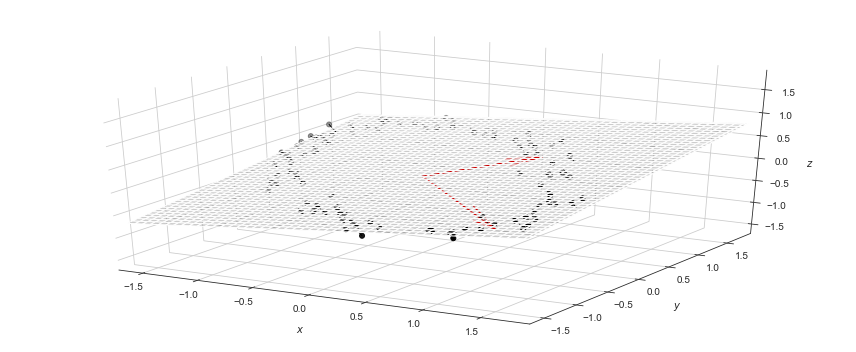

In [30]:
ax = plt.figure(figsize=(12, 5)).gca(projection='3d')

ax.plot_surface(xs, ys, zs, 
                alpha=0.2,
                color='k',
                linewidth=1, 
                antialiased=True)

ax.scatter(x, y, z, c='k', s=25)

for i in range(n_points):
    ax.plot(*zip(proj_matrix.dot(data[i]), data[i]), 
            color='k', lw=1)

origin = np.zeros((2, 3))
X, Y, Z, U, V, W = zip(*np.hstack((origin, C.T)))
ax.quiver(X, Y, Z, U, V, W, color='red')

format3D(ax, limits=list(repeat((min_, max_), 3)))
plt.tight_layout()

### 2D Representation

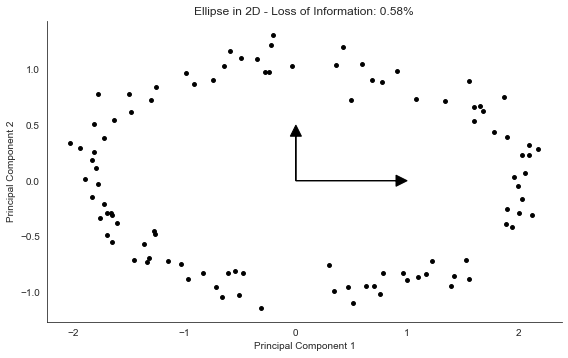

In [31]:
data_3D_inv = pca.inverse_transform(data_2D)
avg_error = np.mean(np.sum(np.square(data_3D_inv-data), axis=1))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, aspect='equal',
                     xlabel='Principal Component 1',
                     ylabel='Principal Component 2',
                     title=f'Ellipse in 2D - Loss of Information: {avg_error:.2%}')

ax.scatter(data_2D[:, 0], data_2D[:, 1], color='k', s=15)
ax.arrow(0, 0, 0, .5, head_width=0.1, length_includes_head=True,
         head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.1, length_includes_head=True,
         head_length=0.1, fc='k', ec='k')
sns.despine()
fig.tight_layout()

### How many Components to represent 64 dimensions?

In [32]:
n_classes = 10
digits = load_digits(n_class=n_classes)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_samples, n_features

(1797, 64)

#### Evaluate the cumulative explained variance 

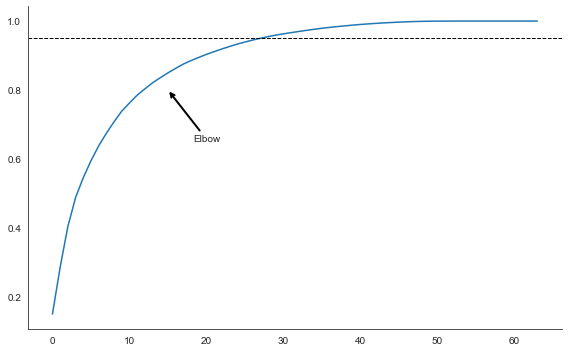

In [33]:
pca = PCA(n_components=64).fit(X)
pd.Series(pca.explained_variance_ratio_).cumsum().plot(figsize=(8, 5))
plt.annotate('Elbow', xy=(15, .8), xycoords='data', xytext=(20, .65),
    textcoords='data', horizontalalignment='center',
    arrowprops=dict(color='k', lw=2, arrowstyle="->")
)
plt.axhline(.95, c='k', lw=1, ls='--')
sns.despine()
plt.tight_layout();

### Automate generation of Components

In [34]:
pca = PCA(n_components=.95).fit(X)
pca.components_.shape

(29, 64)